In [ ]:
import pickle

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model=pickle.load(open('/content/drive/MyDrive/model_saved','rb'))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
import numpy as np
import pandas as pd

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bhavyegupta17","key":"7af0f01c2b205e4040a2cebba7a3aead"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json  ~/.kaggle

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:22<00:00, 135MB/s]
100% 2.29G/2.29G [00:22<00:00, 111MB/s]


In [ ]:
! unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [ ]:
labels = ['PNEUMONIA','NORMAL']
img_size = 150
def get_data(data_dir):
    data =[]
    for label in labels:
        path = os.path.join(data_dir,label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try :
                img_arr = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr,(img_size,img_size)) #Reshaping Images to preferred Size
                data.append([resized_arr,class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
train = get_data('/content/chest_xray/train')
test = get_data('/content/chest_xray/test')
val = get_data('/content/chest_xray/val')

<ipython-input-12-76e38656cdbc>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train :
    x_train.append(feature)
    y_train.append(label)
for feature, label in test :
    x_test.append(feature)
    y_test.append(label)
for feature, label in val :
    x_val.append(feature)
    y_val.append(label)

In [ ]:
positives = []
negatives =[]
for i in range(len(y_train)):
    if y_train[i]:
        positives.append(x_train[i])
    else : 
        negatives.append(x_train[i])

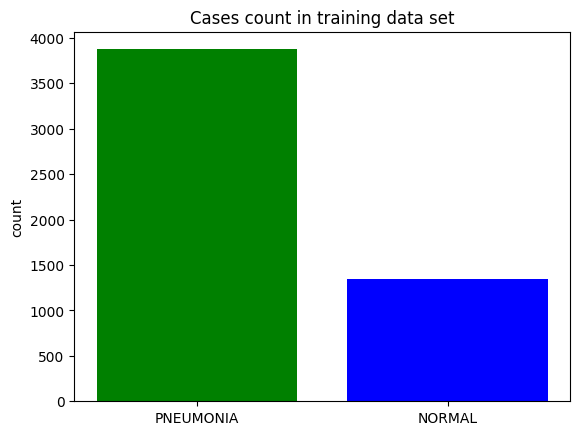

In [ ]:
plt.bar(labels,[len(negatives),len(positives)],color=["green","blue"])
plt.title("Cases count in training data set")
plt.ylabel("count")
plt.show()

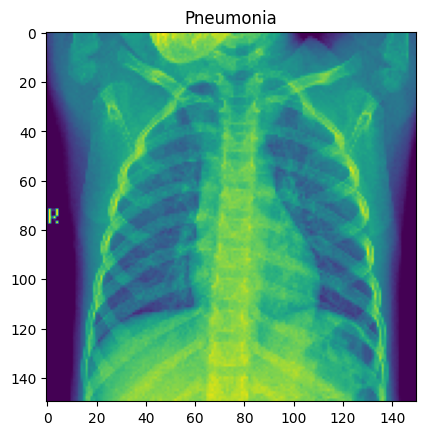

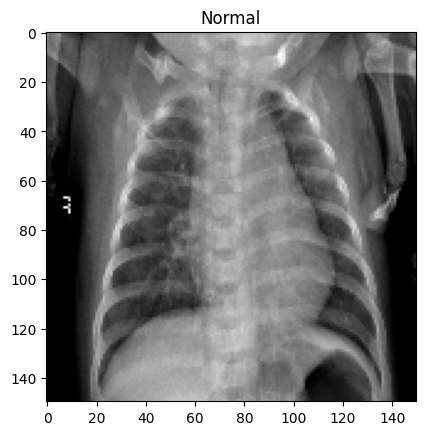

In [ ]:
plt.imshow(positives[0])
plt.title("Pneumonia")
plt.show()

plt.imshow(negatives[4],cmap="gray")
plt.title("Normal")
plt.show()

In [ ]:
x_train = np.array(x_train)/255
x_val = np.array(x_val)/255
x_test = np.array(x_test)/255

In [ ]:
# resize data for deep learning 
x_train = x_train.reshape(-1,img_size,img_size,1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1,img_size,img_size,1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1,img_size,img_size,1)
y_test = np.array(y_test)

In [ ]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y_val = y_val.reshape(-1,1)

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center = False, # set input mean to 0 over the dataset
        samplewise_center = False, # set each sample mean to 0
        featurewise_std_normalization = False, # divide inputs by std of the dataset 
        samplewise_std_normalization = False, # divide each input by its std
        zca_whitening=False, # apply ZCA whitening
        rotation_range=30, # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range=0.2, # Randomly zoom image 
        width_shift_range = 0.1, # randomly shift images horizontally (fraction of total width)
        height_shift_range =0.1, # randomly shift images vertically (fraction of total height)
        horizontal_flip=True, # randomly flip images
        vertical_flip=False # randomly flip images
)

datagen.fit(x_train)

In [ ]:
print("Loss of the model is -", model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is -", model.evaluate(x_test,y_test)[1]*100,"%")

20/20 [==============================] - 12s 544ms/step - loss: 0.3423 - accuracy: 0.8574
Loss of the model is - 0.3423478603363037
20/20 [==============================] - 12s 606ms/step - loss: 0.3423 - accuracy: 0.8574
Accuracy of the model is - 85.73718070983887 %


In [ ]:
predictions = model.predict(x_test)
for i in range(len(predictions)):
    predictions[i] = 1 if predictions[i]>0.5 else 0

20/20 [==============================] - 12s 595ms/step


In [ ]:
print(classification_report(y_test,predictions, target_names=['Pneumonia (Class 0)', 'Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.96      0.81      0.88       390
   Normal (Class 1)       0.75      0.94      0.83       234

           accuracy                           0.86       624
          macro avg       0.85      0.87      0.85       624
       weighted avg       0.88      0.86      0.86       624



In [ ]:
cm = confusion_matrix(y_test,predictions)
cm = pd.DataFrame(cm,index = ['0','1'], columns = ['0','1'])
cm

,0,1
0,315,75
1,14,220


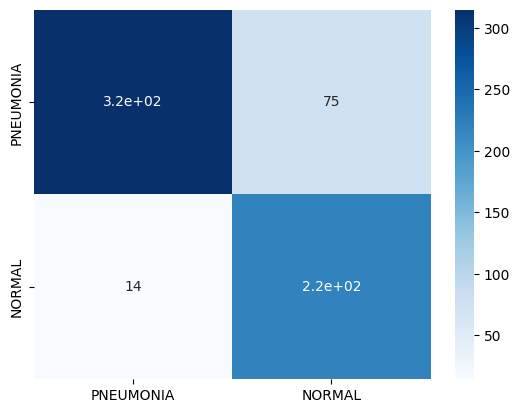

In [ ]:
sns.heatmap(cm,cmap="Blues",annot=True, xticklabels = labels,yticklabels=labels)
plt.show()

In [ ]:
def pneumoniaPrediction(img):
    img = np.array(img)/255
    img = img.reshape(-1,150,150,1)
    isPneumonic = model.predict(img)[0]
    imgClass = 'Pneumonia' if isPneumonic<0.5 else "Normal"
    return imgClass

In [ ]:
pr = model.predict(x_test)
for i in range(len(pr)):
    if pr[i]>0.5:
        pr[i]=0
    else : 
        pr[i]=1

20/20 [==============================] - 12s 590ms/step


In [ ]:
import IPython
from IPython.display import display

In [ ]:
def prepare(filepath):
    IMG_SIZE=150
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

1/1 [==============================] - 0s 37ms/step
Normal 



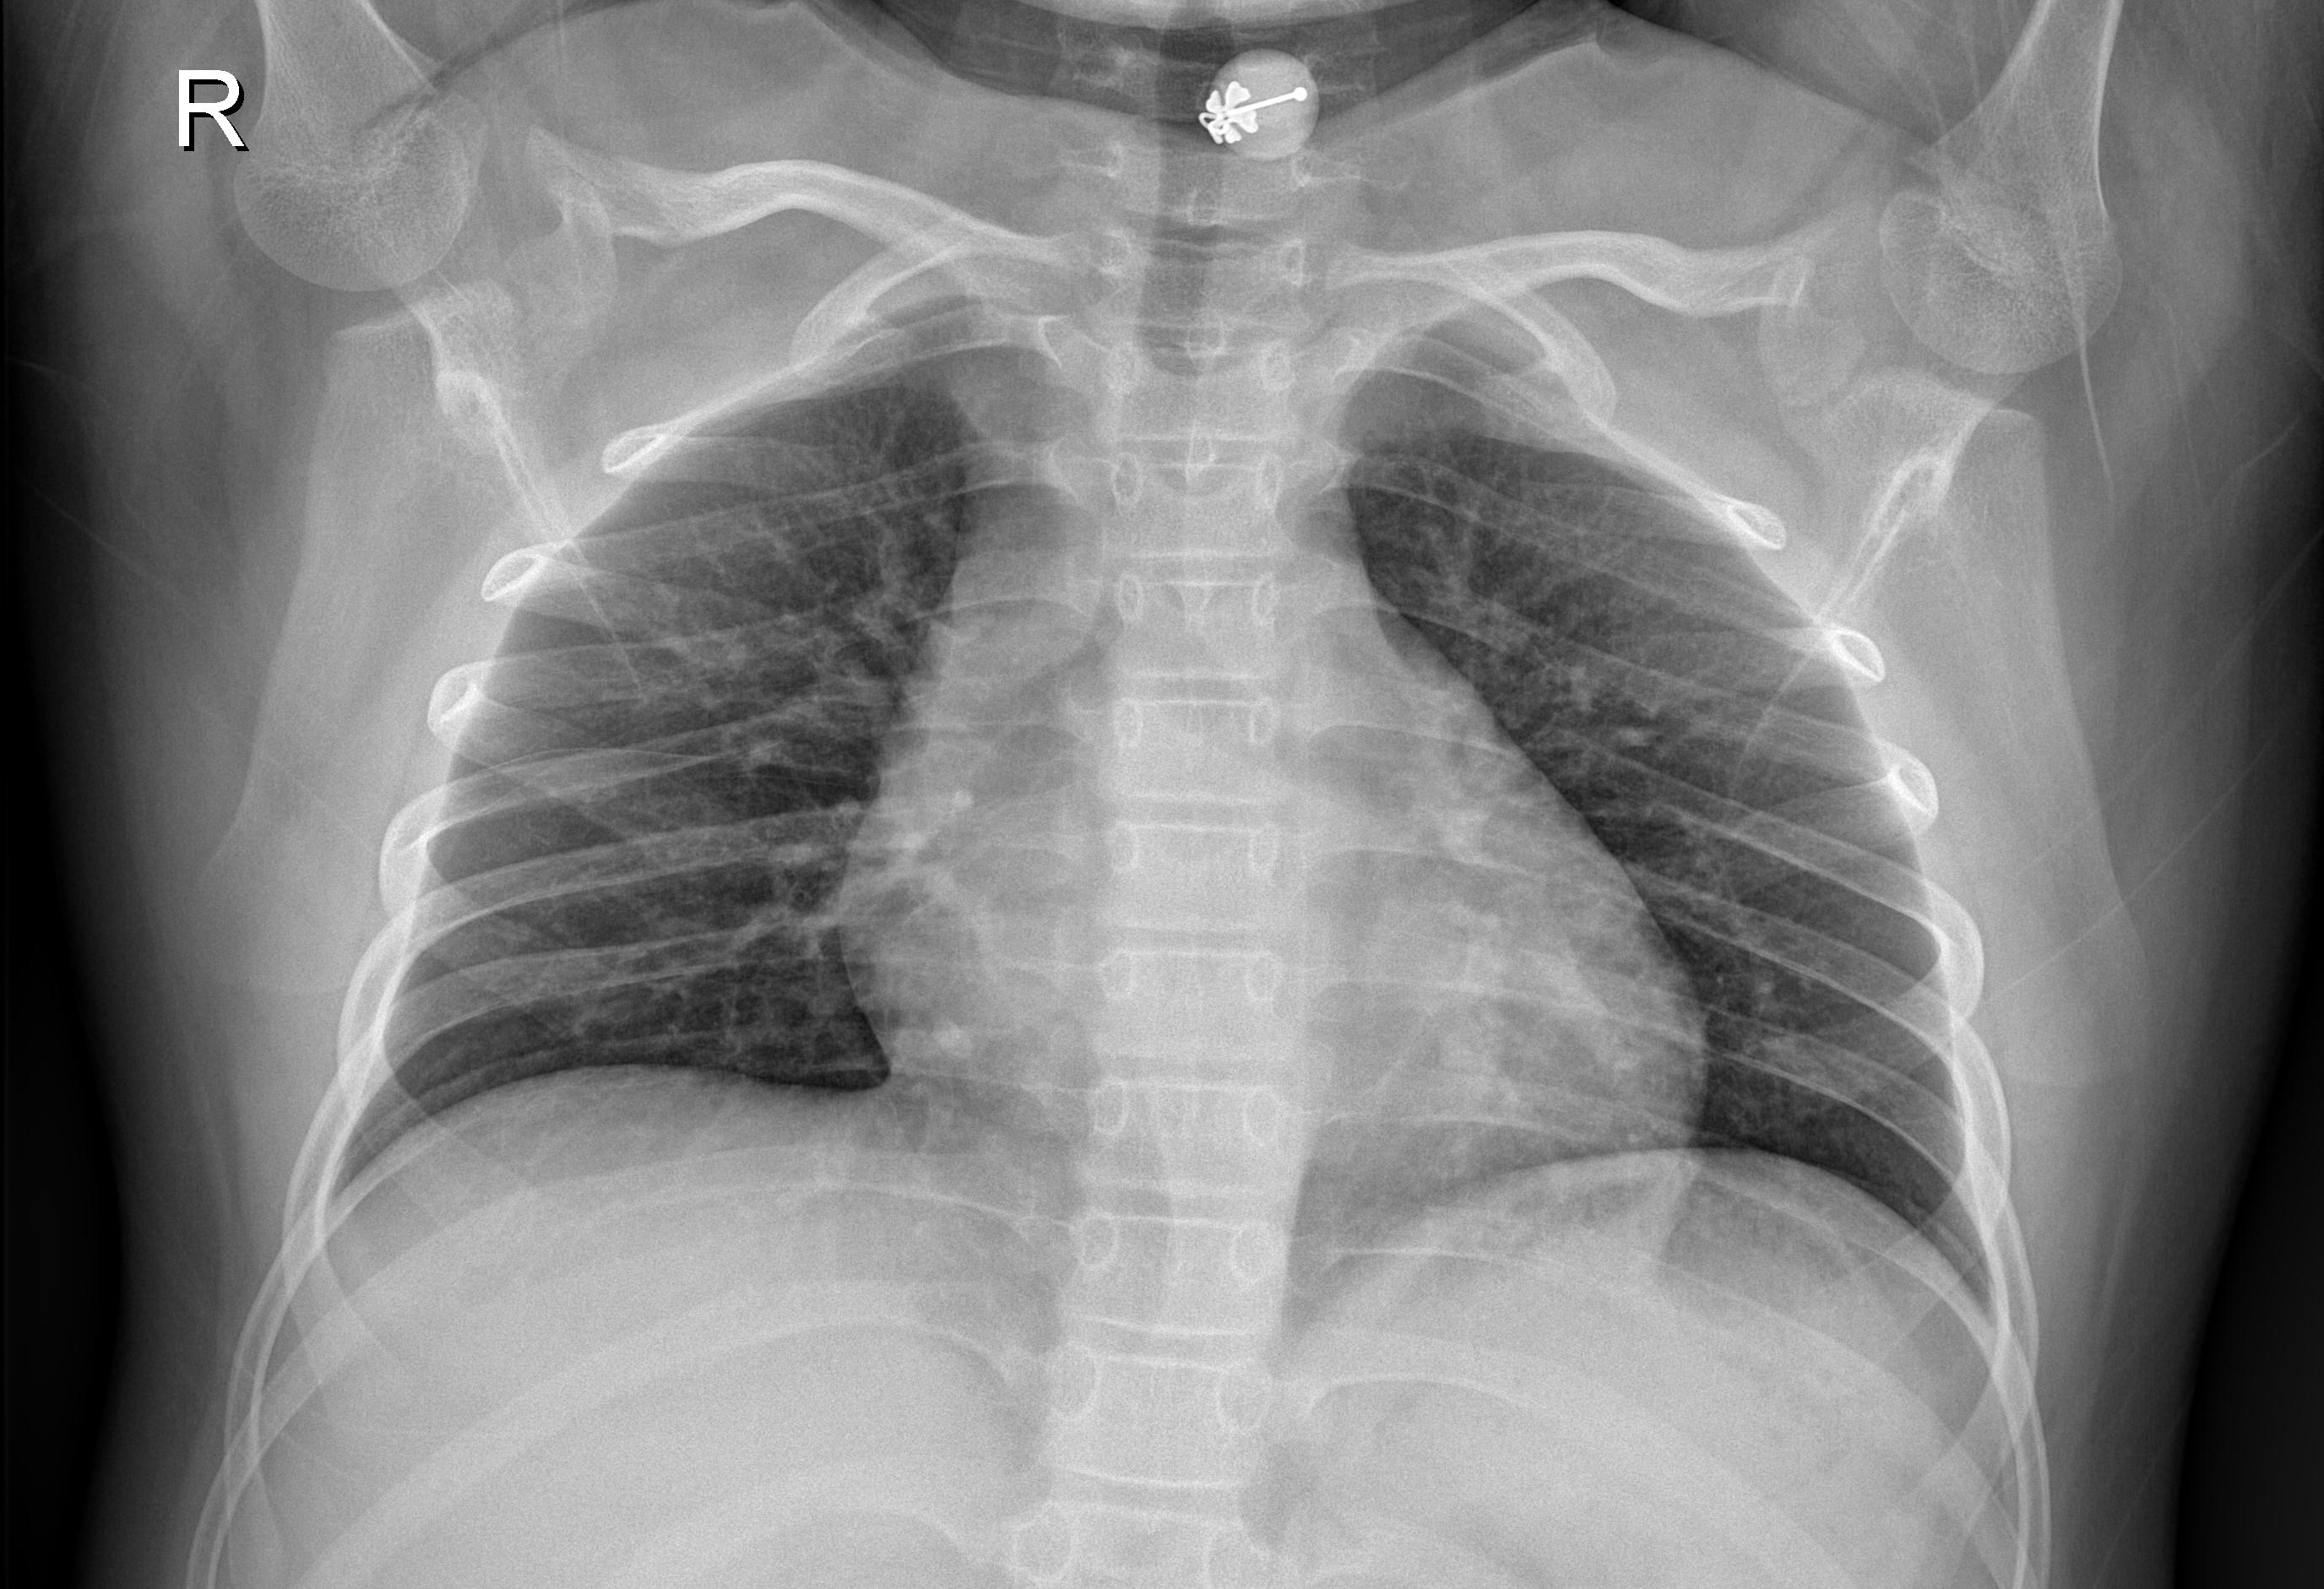

In [ ]:
a='/content/chest_xray/test/NORMAL/IM-0050-0001.jpeg'
predict = pneumoniaPrediction([prepare(a)])
print(predict,"\n")
IPython.display.Image(filename=a,width=250,height=250)

1/1 [==============================] - 0s 60ms/step
Pneumonia 



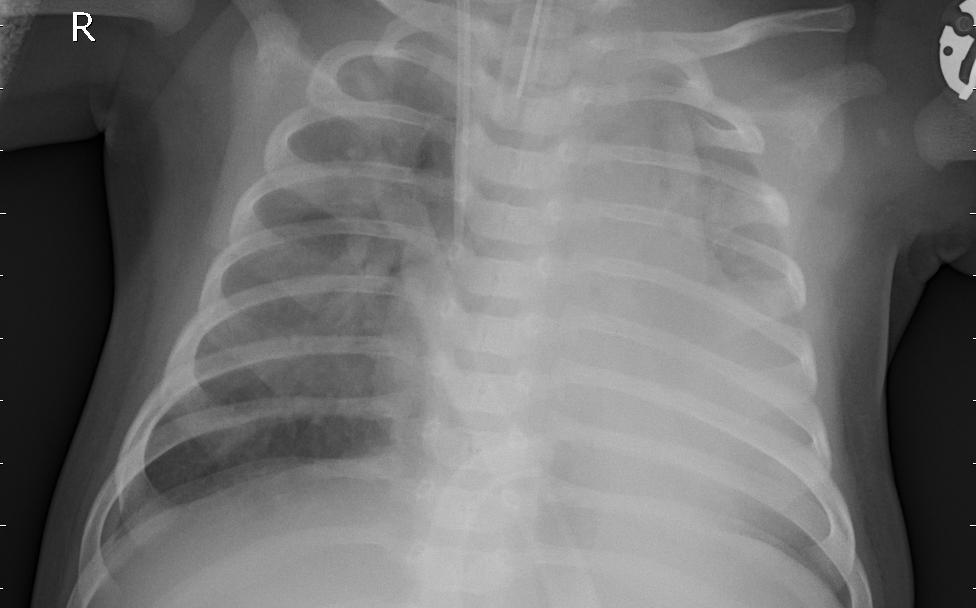

In [ ]:
a='/content/chest_xray/test/PNEUMONIA/person124_bacteria_589.jpeg'
predict = pneumoniaPrediction([prepare(a)])
print(predict,"\n")
IPython.display.Image(filename=a,width=250,height=250)

In [ ]:
pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.1/288.1 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.6/136.6 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 k

In [ ]:
import gradio
img = gradio.inputs.Image(shape=(150,150))
label=gradio.outputs.Label(num_top_classes=1)

/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:259: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:262: UserWarning: `optional` parameter is deprecated, and it has no effect
  super().__init__(
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:200: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  super().__init__(num_top_classes=num_top_classes, type=type, label=label)


In [ ]:
interface=gradio.Interface(fn=pneumoniaPrediction, title="Pneumonia Detection Using Chest X-Ray Images", inputs=img, outputs=label,interpretation="default")
interface.launch(debug=True, share=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://31be01790b88db4d50.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


1/1 [==============================] - 0s 64ms/step
